# Sentiment Analysis usando Deep Learning para español en textos cortos

# 1. Data Cleaning 

We work on a dataset of tweets labelled as positive or negative, more information about the dataset 
can be found on http://www.sepln.org/workshops/tass/. 

# 2. Vocabulary

## 2.2 Getting train, validation and test subsets

In [1]:
import lib.xmlreader as xml
import lib.utils as ut
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim.models.word2vec

# New Getting Datasets

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
sys.path.insert(0, os.getcwd()+'/fastai/')
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [3]:
YEAR='2017'
DATA_PATH=Path('./DATA/'+YEAR)
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/es/models')
PRE_FINETUNE_PATH=Path('./FINETUNE/'+YEAR)

TWEETSLM_PATH=Path('./TWEETS_LM/'+YEAR)
CLAS_PATH=Path('./TWEETS_CLAS/'+YEAR)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [4]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','. ') for i in tweets])
    tweets = np.array([str(i).replace('&lt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('&gt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('\xa0',' ') for i in tweets])
    
    # Remove accents
    tweets = np.array([strip_accents(i) for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'hyp_link' if i.startswith('.http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [5]:
#!python -m spacy download es
import spacy
spacy.prefer_gpu()
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    labels = df[0].values.astype(np.int64)
    texts = f'{BOS} ' + df[1].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df):
    tok, labels = [], []
    tok_, labels_ = get_texts(df)
    tok += tok_;
    labels += labels_
    return tok, labels

In [6]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [7]:
tweets_trn = np.concatenate([df_trn.values, df_gen.values]) #df_gen[df_gen[0]==2].values, df_gen[df_gen[0]==3].values]) #, df_gen.values])
tweets_val = np.concatenate([df_val.values])
tweets_tst = np.concatenate([df_tst.values])
del df_trn, df_val, df_tst, df_gen

tweets_trn[:5]

array([[3,
        '-Me caes muy bien \n-Tienes que jugar más partidas al lol con Russel y conmigo\n-Por qué tan Otako, deja de ser otako\n-Haber si me muero'],
       [0,
        '@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA'],
       [0,
        '@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero '],
       [1, 'Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps '],
       [0, 'Vale he visto la tia bebiendose su regla y me hs dado muchs grima ']], dtype=object)

In [8]:
tweets_trn[:,1] = preprocess_tweets(tweets_trn[:,1])
tweets_val[:,1] = preprocess_tweets(tweets_val[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [9]:
col_names = ['label', 'tweet']

df_trn = pd.DataFrame({'tweet':tweets_trn[:,1], 'label':tweets_trn[:,0]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_val[:,1], 'label':tweets_val[:,0]}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

del tweets_trn, tweets_val, tweets_tst

In [10]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    3202
0    2600
3    1621
2     803
Name: label, dtype: int64
0    219
1    156
2     69
3     62
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [11]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)
# df_val = balance_df(df_val)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    3202
2    3202
1    3202
0    3202
Name: label, dtype: int64
0    219
1    156
2     69
3     62
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [12]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape

del df_trn, df_val, df_tst

## Classifier tokens

In [13]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None)

In [14]:
tok_trn, trn_labels = get_all(df_trn)
tok_val, val_labels = get_all(df_val)
tok_tst, tst_labels = get_all(df_tst)

In [15]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [16]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [17]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [18]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [19]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

40113

In [20]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [21]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Charge Token and Embedding

In [22]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

tst_clas = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_labels = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()

itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [23]:
print(trn_clas.shape)
print(val_clas.shape)

(12808,)
(506,)


In [24]:
len(trn_clas[1])

28

In [25]:
BACKBONE_MODEL = TWEETSLM_PATH/'models/lm3_wgts.h5'

In [26]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

In [27]:
embedding_matrix = to_np(wgts['0.encoder.weight'])
row_m = embedding_matrix.mean(0)

In [28]:
print(embedding_matrix.shape)
print(wgts['1.decoder.weight'].shape)

(40113, 400)
torch.Size([40113, 400])


# 3. Preparing Data

In [31]:
embedding_matrix[stoi['hola']].shape

(400,)

In [32]:
# !conda install keras -y
from keras.preprocessing.sequence import pad_sequences
x_train_seq = pad_sequences(trn_clas, maxlen=32)
x_val_seq   = pad_sequences(val_clas, maxlen=32)
x_test_seq  = pad_sequences(tst_clas, maxlen=32)
print('Shape of data train tensor:', x_train_seq.shape)
print('Shape of data val  tensor:', x_val_seq.shape)
print('Shape of data test  tensor:', x_test_seq.shape)

Using TensorFlow backend.


Shape of data train tensor: (12808, 32)
Shape of data val  tensor: (506, 32)
Shape of data test  tensor: (1899, 32)


In [33]:
x_train_seq[0]

array([    2,  4888,  2786,    80,    86,     5,     0,     6,   458,    39,  7678,    40,  3127,    24,
           0,    14,   390,     5, 12772,     6,   104, 33759,     8,   387,     4,    61, 33759,     5,
           0,    34,    19,  1069], dtype=int32)

# Model: Convolutional Neural Network

In [34]:
import tensorflow as tf
import keras 
from keras import losses

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


config = tf.ConfigProto(intra_op_parallelism_threads=4, \
                        inter_op_parallelism_threads=4, \
                        allow_soft_placement=True,\
                        device_count = {'CPU' : 1, 'GPU' : 0})

sess = tf.Session(config=config)
K.set_session(sess)
    
seed = 0

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D

tweet_input = Input(shape=(32,), dtype='int32')

tweet_encoder   = Embedding(len(stoi), 400, weights=[embedding_matrix], input_length=32, trainable=False)(tweet_input)
bigram_branch   = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch   = GlobalMaxPooling1D()(bigram_branch)
bigram_branch   = Dropout(0.7)(bigram_branch)
trigram_branch  = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch  = GlobalMaxPooling1D()(trigram_branch)
trigram_branch   = Dropout(0.7)(trigram_branch)
#fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
#fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
# merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = concatenate([bigram_branch, trigram_branch], axis=1)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.7)(merged)

merged = Dense(4)(merged)
output = Activation('softmax')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

[]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 400)      16045200    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 31, 100)      80100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D) 

In [35]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return
 
metrics = Metrics()

In [36]:
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

filepath="model/CNN_2019_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1)#, save_best_only=True, mode='max')

model.fit(x_train_seq, to_categorical(trn_labels), batch_size=256, epochs=50,
                     validation_data=(x_val_seq, to_categorical(val_labels)), shuffle=True, callbacks = [checkpoint, metrics])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12808 samples, validate on 506 samples
Epoch 1/50
12808/12808 [==============================] - 4s 344us/step - loss: 1.6722 - acc: 0.2579 - val_loss: 1.3908 - val_acc: 0.1225

Epoch 00001: saving model to model/CNN_2019_best_weights.01-0.1225.hdf5
 — val_f1: 0.056245 — val_precision: 0.155318 — val_recall 0.247109
Epoch 2/50
  768/12808 [>.............................] - ETA: 2s - loss: 1.4067 - acc: 0.2617

/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


12808/12808 [==============================] - 3s 230us/step - loss: 1.3924 - acc: 0.2681 - val_loss: 1.3906 - val_acc: 0.1245

Epoch 00002: saving model to model/CNN_2019_best_weights.02-0.1245.hdf5
 — val_f1: 0.060272 — val_precision: 0.196985 — val_recall 0.249173
Epoch 3/50
  512/12808 [>.............................] - ETA: 3s - loss: 1.3725 - acc: 0.2754

/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


12808/12808 [==============================] - 3s 251us/step - loss: 1.3790 - acc: 0.2794 - val_loss: 1.3855 - val_acc: 0.2312

Epoch 00003: saving model to model/CNN_2019_best_weights.03-0.2312.hdf5
 — val_f1: 0.157006 — val_precision: 0.416291 — val_recall 0.272777
Epoch 4/50
12808/12808 [==============================] - 3s 253us/step - loss: 1.3540 - acc: 0.3125 - val_loss: 1.3635 - val_acc: 0.3577

Epoch 00004: saving model to model/CNN_2019_best_weights.04-0.3577.hdf5
 — val_f1: 0.288061 — val_precision: 0.424482 — val_recall 0.331700
Epoch 5/50
12808/12808 [==============================] - 3s 222us/step - loss: 1.3229 - acc: 0.3543 - val_loss: 1.3418 - val_acc: 0.4704

Epoch 00005: saving model to model/CNN_2019_best_weights.05-0.4704.hdf5
 — val_f1: 0.371931 — val_precision: 0.403893 — val_recall 0.379339
Epoch 6/50
12808/12808 [==============================] - 3s 230us/step - loss: 1.2939 - acc: 0.3715 - val_loss: 1.3089 - val_acc: 0.4941

Epoch 00006: saving model to model/

In [37]:
from sklearn.metrics import f1_score

f1_score(np.argmax(model.predict(x_val_seq), axis=1), val_labels, average='macro')

0.4639284574744051

In [38]:
model.evaluate(x=x_val_seq, y=to_categorical(val_labels))

506/506 [==============================] - 0s 142us/step


[1.16771805050816, 0.5612648222521831]

In [39]:
f1 = f1_score(tst_labels, np.argmax(model.predict(x_test_seq), axis=1), average='macro')
print('F1(macro) = ', f1)

F1(macro) =  0.4362032175799696


In [42]:
from keras.models import load_model

loaded_CNN_model = load_model('model/CNN_2019_best_weights.34-0.5573.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=to_categorical(tst_labels))

1899/1899 [==============================] - 0s 199us/step


[1.1817719544970153, 0.545023696808014]

In [43]:
f1 = f1_score(tst_labels, np.argmax(loaded_CNN_model.predict(x_test_seq), axis=1), average='macro')
print('F1(macro) = ', f1)

acc = (np.argmax(loaded_CNN_model.predict(x_test_seq), axis=1) == tst_labels).mean()
print('Accuracy  = ', acc)

F1(macro) =  0.4482876701553635
Accuracy  =  0.5450236966824644


In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

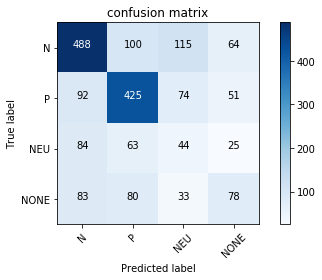

In [46]:
cnf_matrix = confusion_matrix(tst_labels, np.argmax(loaded_CNN_model.predict(x_test_seq), axis=1))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

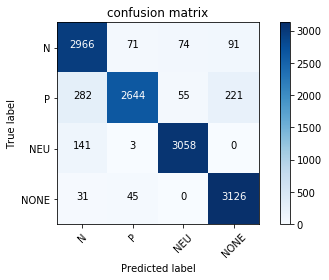

In [47]:
cnf_matrix = confusion_matrix(trn_labels, np.argmax(model.predict(x_train_seq), axis=1))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [ ]:
#from keras.models import load_model

#best_model = load_model('model/CNN_best_weights.01-0.7500.hdf5')

In [56]:
test_values = np.argmax(loaded_CNN_model.predict(x_test_seq), axis = 1)

In [54]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [57]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(len(test_values))
    for i,tweet in enumerate(root.iter('tweet')): 
        #print(i)
        val = getLabel(test_values[i])
        #print(val, test_values[i])
        ID = tweet.find('tweetid').text
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [58]:
#test_values = np.argmax(best_model.predict(x_test_set), axis = 1)

In [59]:
putTestValue("../database/TASS/TASS2018/task1-Test.xml", "output_cnn_alldata_20180408-2.txt")

1428
